Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [3]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [4]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from nn import *
import pickle

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    final_control = us[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state, final_control)


In [6]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

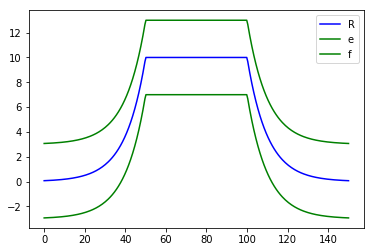

In [7]:
def lane(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

def nominal(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

posx_path = np.linspace(0, 150, 300)
x_path = [[posx_path[i], lane(posx_path[i])[0], 10, lane(posx_path[i])[1]] for i in range(300)]


posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend("Reference Path")

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[3, 3] = 0.0


R = np.eye(dynamics.action_size)
R[0, 0] = 1.0
R[1, 1] = 1.0

barriers = np.array([0, 1, 0, 0]) 

q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1., 0, 0]], [[0, -1., 0, 0]]])
b = np.array([[3.0], [3.0]])
q1 = [1, 1]
q2 = [.5, .5]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])


Now use iLQR to solve this trajectory following problem. Safety constraint is added such that the vehicle stay within the boundaries. The vehicles are initialized at $(0, 0)$ with velocities $10$. The look ahead horizon is 30.

In [35]:
N = len(x_path)
H = 30  # Number of time steps in trajectory.
J_hist = []
expert_traj = []

x0 = x_path[0][:]  # Initial state.
# Random initial action path.
#us_init = np.random.uniform(-1, 1, (H - 1, dynamics.action_size))
us_init = np.zeros((H - 1, dynamics.action_size))

for i in range(0, int(N - H) + 1):
    k = 1
    if i % k != 0:
        continue
        #pass
    x_path_ = x_path[i: i + H]
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2, x_path = x_path_, x_nominal = nominal)
    ilqr = iLQR(dynamics, cost, H - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    x0 = xs[k][:]
    expert_traj = expert_traj + [[xs[i], us[i]] for i in range(k)]



iteration 0 accepted [0.06312485] [14.50776647  0.27244603 10.00793916  0.02001785] [-0.00055011 -0.00332033]
iteration 0 accepted [0.06910697] [15.00871879  0.2868433  10.00856882  0.02071845] [-0.00057159 -0.00374389]
iteration 0 accepted [0.07556337] [15.50969902  0.301692   10.00919825  0.02171402] [-0.00059338 -0.00398921]
iteration 0 accepted [0.08257211] [16.01069765  0.31717124 10.0098232   0.02287637] [-0.00061511 -0.00415798]
iteration 0 accepted [0.09020402] [16.51170685  0.33339149 10.01044056  0.02414261] [-0.00063655 -0.00430141]
iteration 0 accepted [0.09852836] [17.01272028  0.35043602 10.01104838  0.02547763] [-0.00065755 -0.00444935]
iteration 0 accepted [0.10761503] [17.51373296  0.36836924 10.01164583  0.02686594] [-0.00067803 -0.00461666]
iteration 0 accepted [0.11753754] [18.01474072  0.3872444  10.01223278  0.02830439] [-0.00069799 -0.00480879]
iteration 0 accepted [0.12837567] [18.51573973  0.40710949 10.01280957  0.02979664] [-0.00071746 -0.00502614]
iteration 

iteration 0 accepted [98.9236087] [51.03158019  8.83590572 10.32181051  0.18677559] [-0.0163516  0.0294037]
iteration 0 accepted [105.30762303] [51.55332212  8.89959164 10.33622621  0.16088762] [-0.01702882  0.03848565]
iteration 0 accepted [111.42845732] [52.06503828  8.97753392 10.35259469  0.14637029] [-0.01786778  0.04687285]
iteration 0 accepted [117.42178097] [52.58678421  9.02930905 10.36453883  0.13851402] [-0.01836731  0.05184711]
iteration 0 accepted [123.24447754] [53.10842951  9.07638108 10.37552135  0.13455809] [-0.0187862   0.05652489]
iteration 0 accepted [128.92298608] [53.63232939  9.1116242  10.38393494  0.13199172] [-0.01901701  0.06068102]
iteration 0 accepted [134.4763437] [54.15696286  9.13388122 10.39007274  0.128989  ] [-0.01908026  0.0654207 ]
iteration 0 accepted [139.88406468] [54.68293952  9.14192285 10.39303052  0.12477453] [-0.01891122  0.06994468]
iteration 0 accepted [145.16137403] [55.20903698  9.13464256 10.39307391  0.11873967] [-0.01852896  0.0749517

iteration 0 accepted [157.04163992] [8.72455140e+01 9.46806875e+00 1.01177841e+01 2.15719676e-07] [-3.21888664e-03  1.28338656e-07]
iteration 0 accepted [156.94455233] [8.77495993e+01 9.46806863e+00 1.01140821e+01 1.56369612e-07] [-3.09922082e-03  9.31016392e-08]
iteration 0 accepted [156.85359443] [8.82535335e+01 9.46806854e+00 1.01104740e+01 1.11733152e-07] [-2.98379422e-03  6.65751210e-08]
iteration 0 accepted [156.76842784] [8.87573225e+01 9.46806848e+00 1.01069594e+01 7.86153050e-08] [-2.87252230e-03  4.68759267e-08]
iteration 0 accepted [156.6887286] [8.92609720e+01 9.46806843e+00 1.01035379e+01 5.43943121e-08] [-2.76531926e-03  3.24561689e-08]
iteration 0 accepted [156.61418694] [8.97644876e+01 9.46806839e+00 1.01002090e+01 3.69492370e-08] [-2.66209819e-03  2.20616796e-08]
iteration 0 accepted [156.54450699] [9.02678747e+01 9.46806837e+00 1.00969721e+01 2.45893448e-08] [-2.56277133e-03  1.46912224e-08]
iteration 0 accepted [156.47940644] [9.07711388e+01 9.46806835e+00 1.00938263

iteration 0 accepted [39.52482815] [120.74554339   1.36661775  10.35624277  -0.21274404] [-0.01458205 -0.05881813]
iteration 0 accepted [37.94506724] [121.26587659   1.29920109  10.35575675  -0.20445146] [-0.01438774 -0.05766202]
iteration 0 accepted [36.39915571] [121.78633499   1.23516547  10.35471947  -0.19659737] [-0.01417053 -0.05659361]
iteration 0 accepted [34.88376918] [122.30691869   1.17378074  10.35353621  -0.1887919 ] [-0.01396427 -0.05534827]
iteration 0 accepted [33.40239723] [122.82747369   1.11510948  10.35210142  -0.18113771] [-0.01376161 -0.05399911]
iteration 0 accepted [31.95937768] [123.34787072   1.05971505  10.35007859  -0.17401816] [-0.01353097 -0.05283042]
iteration 0 accepted [30.54301022] [123.86884937   1.0052879   10.34875331  -0.16633431] [-0.01336244 -0.05104873]
iteration 0 accepted [29.17066821] [124.38951445   0.95388597  10.34685735  -0.15915373] [-0.01316865 -0.04943489]
iteration 0 accepted [27.83949452] [124.90996533   0.90495078  10.34466634  -0.1

The result can be visulized by executing the following code.

In [38]:
X = []
Y = []
posx = []
posy = []
v = []
theta = []

for i in expert_traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])



posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

#pickle.dump((X, Y), open('expert_traj.p', 'wb'))

The red curve in this plot is the trajecotry of the MPC vehicle. 

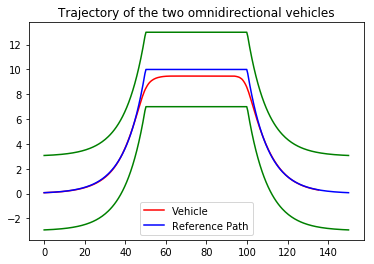

In [39]:

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")

_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

In [31]:
pickle.dump((X, Y), open('expert_pts_17358_H10.p', 'wb'))

Now train a simple regression model to output control given the current coordinate.

In [8]:
n = 10
agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H10', batch_size = 1000, checkpoint = 'checkpoints/mlp_H10_995.pt')

agent.data_process(paths = ['expert_pts_10058_H10.p', 'expert_pts_17358_H10.p'])
#agent.train(num_epoch = 1000)


27416


In [9]:

agent_traj = []
batch_size = 100
for i_batch in range(batch_size):
    agent_traj.append([])
    x0 = [[x_path[0][0] + 1.0 * (2 * random.random() - 1.0), \
              x_path[0][1] + 3.0 * (2 * random.random() - 1.0), \
              x_path[0][2] + 1.0 * (2 * random.random() - 1.0), \
              x_path[0][3] + 3.0 * (2 * random.random() - 1.0)]]  # Initial state.

    N = 300
    n = 10
    for i in range(0, int(N - n) + 1):
        x = []
        for j in x0[0]:
            x.append(j)
        for j in range(len(x_path[i: i + n])):
            for k in range(len(x_path[j + i])):
                x.append(x_path[j + i][k])

        u = agent.run([x])
        agent_traj[-1] = agent_traj[-1] + [[x[:], u[0]]]
        x0 = dynamics.f(x[0:4], u[0], i)

print("Done")

/home/depend/virtualenv_py3/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/depend/virtualenv_py3/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Done


The red curve in the plot shows the trajectory of the regression model controller.

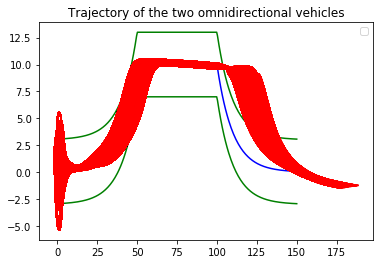

In [15]:
plt.title("Trajectory of the two omnidirectional vehicles")
plt.legend(["Vehicle", "Reference Path"])
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]
plt.plot(posx_, posy_, "b")
plt.plot(posx_, posy_ + 3.0, 'g')
plt.plot(posx_, posy_ - 3.0, 'g')

posx = []
posy = []
v = []
theta = []
for i in agent_traj:
    posx.append([])
    posy.append([])
    v.append([])
    theta.append([])
    for j in i:
        posx[-1].append(j[0][0])
        posy[-1].append(j[0][1])
        v[-1].append(j[0][2])
        theta[-1].append(j[0][3])
        plt.plot(posx[-1], posy[-1], "r")

plt.show()

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


<h2>MPSC Guided Policy Search</h2>

Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=g(x_k, \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& g(x_k, \theta)\\
u_k + \delta u_k &=& g(x_k + \delta x_k, \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x g(x_k, \theta) \delta x_k + \nabla_\theta g(x_k, \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.

To estimate the perturbation on the learning model, one choise is to use L-2 norm of the perturbation on the model parameters, i.e. $||\delta \theta||^2_2$, the other choise is to evaluate the increase on the loss $J_D()$ given the same data set $D$, i.e. $J_D (\theta + \delta\theta) - J_D(\theta)$. Note that now the decision variables are $\delta x, \delta u$ and $\delta \theta$. Now we consider using the second choice as the loss function.

Since $J_D(\theta + \delta\theta) - J_D(\theta)\approx\nabla J_D(\theta) \delta \theta\approx \nabla J_D(\theta)\delta\theta + \delta\theta^T \nabla^2 J_D(\theta) \delta\theta $. We can use this Taylor expansion to replace the loss. Assuming that $\theta$ is already a local optimal solution, then $\delta\theta^T\nabla^2 J_D(\theta)\delta\theta$ is positive definite and $\nabla J_D(\theta)\delta\theta=0$. Then we can use the second order term. Since the constraints and objective are convex, this is a convex optimization problem.

\begin{eqnarray}
\underset{\delta\theta}{min}&&\delta\theta^T \nabla J_D(\theta)\delta\theta \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

However, if $\theta$ is not a local optimal solution but an intermediate model parameter, then the loss is linear $\nabla J_D(\theta) \delta\theta$ or quadratic $\nabla J_D(\theta) \delta\theta + \delta\theta^T \nabla^2 J_D(\theta) \delta\theta$. 

For the linear case, the optimization problem is convex but also suffers high approximation error. We can alleviate this issue by adding a trust region regularizer. Thus the objective becomes $\underset{\delta\theta}{min}\ \nabla J_D(\theta) \delta\theta + \lambda ||\delta\theta||^2_2$ where $\lambda$ is a lagrangian variable (constant). The steepest descent direction is $\nabla J_D(\theta) + 2\lambda \delta\theta$.

For the quadratic case, the steepest descent direction is $\nabla J_D(\theta) + \nabla^2 J_D(\theta) + 2\lambda \delta\theta$ where the trust region regularizer is retained.

Naively, the solved $\delta \theta$ can be applied to the learning model parameter in every iteration. For instance, when using policy gradient to train a parameterized policy $\pi_\theta: X\rightarrow U$, after every gradient step $\theta_{i-1} \rightarrow \theta_{i}$, the resulted policy $\pi_{\theta_i}$ is used to generated samples for the next optimization. Then MPC formulated above can be implemented to the unsafe trajectories (or multiple trajecotries nearby the unsafe set) to further update the policy parameter $\theta_i\rightarrow \theta_i + \delta \theta_i$. 

We can also combine the two steps, i.e. perturbing $\theta_{i-1}$ with $\delta\theta_{i-1}$ and updating $\theta_{i-1}\rightarrow \theta_{i}$, since both the search directions contain $\nabla_\theta J_D(\theta_{i-1})$ term. Hence, we can use a line search along $\nabla_\theta J_D(\theta_{i-1})$, perhaps without the trust region regularization, and the constraints confine the step length.


<h2>MPSC Guided Imitation Learning</h2>


Following the afformentioned basic setup, we can use MPSC in imitation learning, not to perturb the model parameter, but perturb the cost function based on the intermediate sample trajectories. 
It is known that the original IRL formula is 
$$\underset{c}{min}\ \underset{\pi}{max}\ \mathbb{E}_{\pi_E}[c(x, u)] - \mathbb{E}_{\pi} [c(x, u)]$$

It is common in model-free approaches that whenever a new intermediate policy $\pi_{\theta_i}$ is obtained, a set of corresponding sample trajecotries are generated to compare with the expert trajectories $E$ and update the cost function. For instance, in WGAN formulated GAIL, the update of the discriminator $D: X\times U\times W\rightarrow \mathbb{R}$ with parameter space $W$ is as follows.

$$\underset{w\in W}{min}\ \mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w)]$$




Our first step is to find the minimal perturbation to the unsafe intermediate sample trajectories while maintaining high performance. Given an unsafe trajecotry $\tau=(x_0,u_0, \ldots, x_T, u_T)$, the quadratic cost matrices $Q, R$ standard for iLQR are obtained from the current cost $D(, ,w_{i-1})$. Then the MPSC problem is as follows.
\begin{eqnarray}
\underset{\delta x, \delta u}{min} && \delta x^T Q \delta x + \delta u^T R \delta u \\
s.t. && \delta x_{k+1} \approx \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k \qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

Then a constraint can be added to the optimal cost problem such that the perturbed trajecotry $\tau+\delta\tau$ has lower cost than $\tau$. 

\begin{eqnarray}
\underset{w}{min}& &\mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w_{i-1})]\\
s.t. && \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w) - \sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w)  \leq 0
\end{eqnarray}

However, since $\tau$ is optimal w.r.t the $\pi_{\theta_i}$ which is optimal w.r.t $D(,, w_{i-1})$, the constraint is mostly unlike to be satisfied under $w_{i-1}$. In other word, the constraint of the problem changes in every iteration and the problem can be infeasible in the beginning of every iteration. To simplify the problem, the constraint can be manipulated as follows.

If function $D$ is convex in terms of $x, u$, then subgradient can be used.
\begin{eqnarray}
&&\sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w) - \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k+\delta x_k,u_k + \delta u_k, w)  \geq 0\\
&\Rightarrow& \underset{g^{(k)}_i\in \partial_{(x, u)} D(x_k+\delta x_k, u_k + \delta u_k ,w)}{min}\  \sum_{(x_k,u_k)\in\tau} g^{(k)}_i \cdot [-\delta x_k, - \delta u_k]^T\geq 0 
\end{eqnarray}

However, it can be problemetic to find the minimal subgradient in practice. The second proposal does not require convexity to be guaranteed. In every iteration, we can consider two cases. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \geq 0$, which implies that $w_{i-1}$ is feasible, then directly use barrier or penalty method to update $w_{i-1}$. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \leq 0$, then the constraint can be tightened by borrowing the left hand side of the inequality. Assume that a feasible update $\delta w_{i-1}$ on $w_{i-1}$ enables $w_i = w_{i-1} + \delta w_{i-1}$ to satisfy the tightened constraint as below.

\begin{eqnarray}
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})\leq \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \\
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) + \sum_{\tau} D(x_k,u_k, w_{i-1})- \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})  \leq 0\\
&&\nabla_w \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1})\delta w_{i-1} - \nabla_w \sum_{\tau} D(x_k,u_k, w_{i-1})\delta  w_{i-1}\leq 0\\
&&\nabla_w \sum_{\tau} [D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - D(x_k,u_k, w_{i-1})]\delta w_{i-1}\leq 0
\end{eqnarray}

As a result, the constraint is linearized. The direction of $\delta w_{i-1}$ can be determined by the gradient of the object while the step length is confined by this linear constraint.
